In [16]:
import pandas as pd
import numpy as np

INPUT = "downloads/all_companies_with_sectors_corrected_final.csv"

# 1) load data
df = pd.read_csv(INPUT, parse_dates=["Date"], low_memory=False)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

cols = ["PX_LAST", "REVENUE", "NET_INCOME", "IS_RD_EXPEND", "CAPEX", "CUR_MKT_CAP"]
for c in cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["CUR_MKT_CAP"])

vars_to_agg = ["PX_LAST", "REVENUE", "NET_INCOME", "IS_RD_EXPEND", "CAPEX"]
df = df.dropna(subset=vars_to_agg, how="all")


df["Quarter"] = df["Date"].dt.to_period("Q").astype(str)

def weighted_agg(group, value_cols, weight_col="CUR_MKT_CAP"):
    w = group[weight_col] if weight_col in group.columns else pd.Series(np.nan, index=group.index)
    out = {}
    for col in value_cols:
        if col not in group.columns:
            out[col] = np.nan
            continue
        val = group[col]
        mask = val.notna() & w.notna() & (w > 0)
        if mask.sum() == 0:
            out[col] = np.nan
        else:
            out[col] = np.average(val[mask], weights=w[mask])
    return pd.Series(out)


sector_df = (
    df.groupby(["Stream", "Quarter"])
      .apply(lambda g: weighted_agg(g, vars_to_agg, weight_col="CUR_MKT_CAP"))
      .reset_index()
)

print("Aggregated shape:", sector_df.shape)
display(sector_df.head(20))

Aggregated shape: (1529, 7)


,Stream,Quarter,PX_LAST,REVENUE,NET_INCOME,IS_RD_EXPEND,CAPEX
0,Downstream (Automotive Semiconductors),2000Q2,59.538,1830.0,266.0,237.0,NaN
1,Downstream (Automotive Semiconductors),2000Q3,39.572,2380.0,581.0,348.0,NaN
2,Downstream (Automotive Semiconductors),2000Q4,28.560,1658.0,280.0,257.0,NaN
3,Downstream (Automotive Semiconductors),2001Q1,30.762,1650.0,23.0,269.0,NaN
4,Downstream (Automotive Semiconductors),2001Q2,20.460,1277.0,-371.0,318.0,NaN
5,Downstream (Automotive Semiconductors),2001Q3,9.972,1085.0,-523.0,344.0,NaN
6,Downstream (Automotive Semiconductors),2001Q4,16.952,1034.0,-331.0,267.0,221.0
7,Downstream (Automotive Semiconductors),2002Q1,19.190,1385.0,-108.0,264.0,145.0
8,Downstream (Automotive Semiconductors),2002Q2,11.803,1404.0,-76.0,237.0,64.0
9,Downstream (Automotive Semiconductors),2002Q3,4.144,1384.0,-506.0,292.0,213.0


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_sector_RnD(sector_df, sectors_to_plot):
    # -------------------------------------------------
    # 1. Filter the data for the desired period & sectors
    # -------------------------------------------------
    df = sector_df[
        (sector_df["Quarter"] > "2000Q1") &
        (sector_df["Quarter"] <= "2025Q2") &
        (sector_df["Stream"].isin(sectors_to_plot))
    ].copy()

    print(f"Selected sectors: {sectors_to_plot}")
    print(f"Filtered dataset shape: {df.shape}")

    
    # -------------------------------------------------
    # 2. Ensure R&D column exists
    # -------------------------------------------------
    if "R&D" not in df.columns:
        if "IS_RD_EXPEND" in df.columns:
            df = df.rename(columns={"IS_RD_EXPEND": "R&D"})
        else:
            raise ValueError("❌ No R&D or IS_RD_EXPEND column found in the dataframe.")


    # -------------------------------------------------
    # 3. Compute Z-score normalization for R&D per sector
    # -------------------------------------------------
    df["R&D_ZSCORE"] = df.groupby("Stream")["R&D"].transform(
        lambda x: (x - x.mean()) / x.std(ddof=0)
    )

    # Drop missing values
    df = df.dropna(subset=["R&D_ZSCORE"])

    print("Data after Z-score normalization:")
    print(df[["Stream", "Quarter", "R&D_ZSCORE"]].head())

    
    # -------------------------------------------------
    # 4. Plot using Seaborn
    # -------------------------------------------------
    sns.set(style="whitegrid", context="talk")

    plt.figure(figsize=(30, 7))
    sns.lineplot(
        data=df,
        x="Quarter",
        y="R&D_ZSCORE",
        hue="Stream",
        lw=2,
        marker="o"
    )

    # -------------------------------------------------
    # 5. Chart styling
    # -------------------------------------------------
    plt.title("Comparison of Sector R&D Expenditures (Z-score Normalized)", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.xticks(rotation=90)

    plt.ylabel("Normalized R&D (Z-score)", fontsize=14)
    plt.legend(title="Sector", loc="upper left")
    plt.grid(alpha=0.3)
    plt.show()



Selected sectors: ['Downstream (Automotive Semiconductors)', 'End Applications (Automotive)']
Filtered dataset shape: (202, 7)
Data after Z-score normalization:
                                   Stream Quarter  R&D_ZSCORE
0  Downstream (Automotive Semiconductors)  2000Q2   -0.374869
1  Downstream (Automotive Semiconductors)  2000Q3    0.449103
2  Downstream (Automotive Semiconductors)  2000Q4   -0.226405
3  Downstream (Automotive Semiconductors)  2001Q1   -0.137327
4  Downstream (Automotive Semiconductors)  2001Q2    0.226408


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


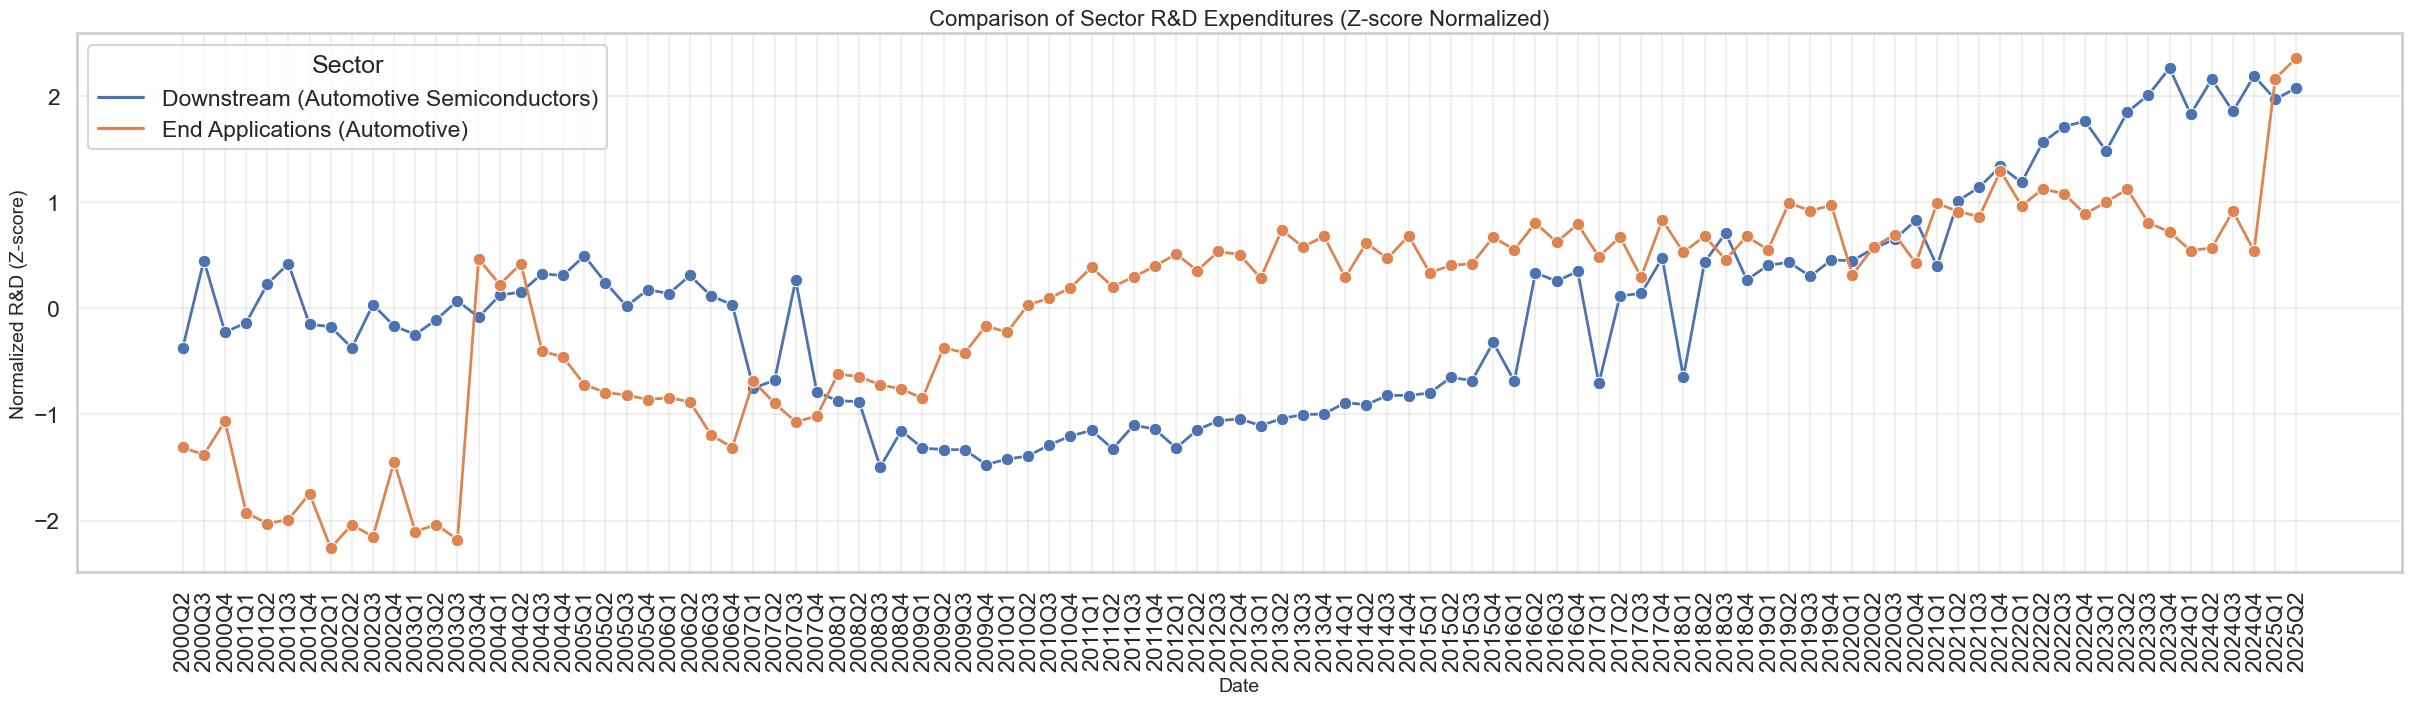

In [18]:
sectors_to_plot = [
'Downstream (Automotive Semiconductors)',
 'End Applications (Automotive)',
]
plot_sector_RnD(sector_df, sectors_to_plot)

In [19]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name=""):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}")
    print(f"  Test Statistic : {result[0]:.4f}")
    print(f"  p-value         : {result[1]:.4f}")
    if result[1] < 0.05:
        print("  ✅ Stationary (reject H0)")
    else:
        print("  ❌ Non-stationary (cannot reject H0)")
    print("-"*40)

for sector in sectors_to_plot:
    tmp = sector_df[(sector_df["Quarter"] > "2000Q1") &
        (sector_df["Quarter"] <= "2025Q2") & (sector_df["Stream"] == sector)].sort_values("Quarter")
    adf_test(tmp["IS_RD_EXPEND"], sector)


ADF Test for Downstream (Automotive Semiconductors)
  Test Statistic : -0.3789
  p-value         : 0.9136
  ❌ Non-stationary (cannot reject H0)
----------------------------------------
ADF Test for End Applications (Automotive)
  Test Statistic : -1.0211
  p-value         : 0.7455
  ❌ Non-stationary (cannot reject H0)
----------------------------------------


In [20]:
tmp["R&D_DIFF"] = tmp["IS_RD_EXPEND"].diff()

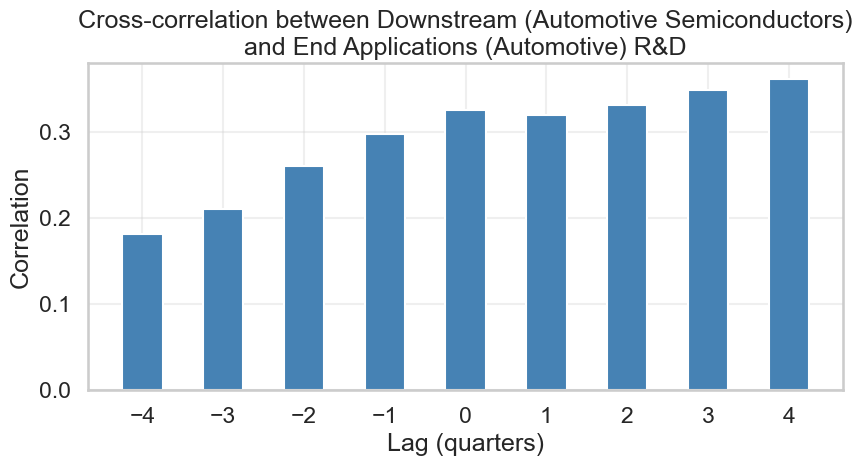

Cross-correlation values (negative → B leads A, positive → A leads B):
Lag -4: 0.1815
Lag -3: 0.2110
Lag -2: 0.2606
Lag -1: 0.2981
Lag +0: 0.3264
Lag +1: 0.3197
Lag +2: 0.3321
Lag +3: 0.3497
Lag +4: 0.3625


In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import ccf

# ---------------------------------------------
# 1. Filter and align the two sectors
# ---------------------------------------------
sectorA = (
    sector_df[
        (sector_df["Quarter"] > "2000Q1")
        & (sector_df["Quarter"] <= "2025Q2")
        & (sector_df["Stream"] == "Downstream (Automotive Semiconductors)")
    ]
    .sort_values("Quarter")["IS_RD_EXPEND"]
)

sectorB = (
    sector_df[
        (sector_df["Quarter"] > "2000Q1")
        & (sector_df["Quarter"] <= "2025Q2")
        & (sector_df["Stream"] == "End Applications (Automotive)")
    ]
    .sort_values("Quarter")["IS_RD_EXPEND"]
)

# ---------------------------------------------
# 2. Compute cross-correlation for both directions
# ---------------------------------------------
corr_pos = ccf(sectorA, sectorB)          # A leads B (positive lags)
corr_neg = ccf(sectorB, sectorA)          # B leads A (negative lags)

max_lag = 4  # number of lags to show on each side

# Take only the first 4 values for both directions
corr_pos = corr_pos[:max_lag + 1]
corr_neg = corr_neg[:max_lag + 1][1:]  # skip lag=0 to avoid duplicate center

# Combine negative and positive parts symmetrically
corr_full = np.concatenate((corr_neg[::-1], corr_pos))  # optional: flip sign for symmetry
lags = list(range(-max_lag, max_lag + 1))

# ---------------------------------------------
# 3. Plot
# ---------------------------------------------
plt.figure(figsize=(9, 5))
plt.bar(lags, corr_full, color="steelblue", width=0.5)
plt.axhline(0, color="k", linewidth=0.8)
plt.title(
    "Cross-correlation between Downstream (Automotive Semiconductors)\n"
    "and End Applications (Automotive) R&D"
)
plt.xlabel("Lag (quarters)")
plt.ylabel("Correlation")
plt.xticks(range(-max_lag, max_lag + 1))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 4. Print correlation values for interpretation
# ---------------------------------------------
print("Cross-correlation values (negative → B leads A, positive → A leads B):")
for lag, val in zip(lags, corr_full):
    print(f"Lag {lag:+d}: {val:.4f}")



In [22]:
from statsmodels.tsa.stattools import grangercausalitytests

data = pd.concat([sectorA.reset_index(drop=True), sectorB.reset_index(drop=True)], axis=1)
data.columns = sectors_to_plot

grangercausalitytests(data, maxlag=4)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4195  , p=0.1231  , df_denom=97, df_num=1
ssr based chi2 test:   chi2=2.4944  , p=0.1143  , df=1
likelihood ratio test: chi2=2.4638  , p=0.1165  , df=1
parameter F test:         F=2.4195  , p=0.1231  , df_denom=97, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2288  , p=0.0440  , df_denom=94, df_num=2
ssr based chi2 test:   chi2=6.8011  , p=0.0334  , df=2
likelihood ratio test: chi2=6.5776  , p=0.0373  , df=2
parameter F test:         F=3.2288  , p=0.0440  , df_denom=94, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5518  , p=0.0604  , df_denom=91, df_num=3
ssr based chi2 test:   chi2=8.2441  , p=0.0412  , df=3
likelihood ratio test: chi2=7.9157  , p=0.0478  , df=3
parameter F test:         F=2.5518  , p=0.0604  , df_denom=91, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8604  , p=0.0280  , df_d

{1: ({'ssr_ftest': (2.419526934118171, 0.1230879259627533, 97.0, 1),
   'ssr_chi2test': (2.4943576640393514, 0.11425498330982567, 1),
   'lrtest': (2.4637563895114454, 0.11649987633598748, 1),
   'params_ftest': (2.4195269341117105, 0.12308792596324615, 97.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.2287869874332737, 0.04403752313483984, 94.0, 2),
   'ssr_chi2test': (6.801061952253066, 0.03335555425443748, 2),
   'lrtest': (6.5776299529172775, 0.0372980222525247, 2),
   'params_ftest': (3.228786987433315, 0.04403752313483812, 94.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.5517595700875044, 0.06044772529172322, 91.0, 3),
   'ssr_chi2test': (8.24414630335963, 0.04122642921713336, 3),
   'lrtest': (7.915678932079004, 0.047786894042628356, 3),
   'params_ftest': (2.551759570086991, 0.06044772529176137, 91.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0.

In [23]:
from statsmodels.tsa.stattools import grangercausalitytests

# Inverse the order of columns: now testing if Automotive → Semiconductors
data_reverse = pd.concat([
    sectorB.reset_index(drop=True),
    sectorA.reset_index(drop=True)
], axis=1)
data_reverse.columns = sectors_to_plot[::-1]


# Run the Granger test for up to 4 lags
grangercausalitytests(data_reverse, maxlag=4)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9453  , p=0.3333  , df_denom=97, df_num=1
ssr based chi2 test:   chi2=0.9746  , p=0.3235  , df=1
likelihood ratio test: chi2=0.9699  , p=0.3247  , df=1
parameter F test:         F=0.9453  , p=0.3333  , df_denom=97, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3746  , p=0.6886  , df_denom=94, df_num=2
ssr based chi2 test:   chi2=0.7891  , p=0.6740  , df=2
likelihood ratio test: chi2=0.7859  , p=0.6750  , df=2
parameter F test:         F=0.3746  , p=0.6886  , df_denom=94, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6853  , p=0.5633  , df_denom=91, df_num=3
ssr based chi2 test:   chi2=2.2141  , p=0.5292  , df=3
likelihood ratio test: chi2=2.1895  , p=0.5340  , df=3
parameter F test:         F=0.6853  , p=0.5633  , df_denom=91, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7629  , p=0.5522  , df_d

{1: ({'ssr_ftest': (0.9453459931377756, 0.3333251251436036, 97.0, 1),
   'ssr_chi2test': (0.974583498080181, 0.3235397218309767, 1),
   'lrtest': (0.9698650650504987, 0.3247138335873505, 1),
   'params_ftest': (0.9453459931376963, 0.333325125143626, 97.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.37461249144703934, 0.6885774633886992, 94.0, 2),
   'ssr_chi2test': (0.7890773756012104, 0.6739908877630552, 2),
   'lrtest': (0.7859493238424875, 0.6750458517343944, 2),
   'params_ftest': (0.37461249144719905, 0.6885774633885868, 94.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.685314922968163, 0.5632912890154897, 91.0, 3),
   'ssr_chi2test': (2.214094366512527, 0.5291775587703591, 3),
   'lrtest': (2.1894535180047114, 0.534028685683863, 3),
   'params_ftest': (0.6853149229681764, 0.5632912890154813, 91.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1